<a href="https://www.kaggle.com/code/wangyuweikiwi/mimi-iii-time-series-data-preprocessing?scriptVersionId=198485535" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Load data from dataset

As a demo, only use some of the values in vitals_records, not all

In [1]:
import pickle
import copy
import numpy as np


with open('/kaggle/input/mimic-iii-time-series-filters-by-measurement-ids/vitals_records_10000.p', 'rb') as file:
    vitals = pickle.load(file)
print(len(vitals))

5000


In [2]:
def list_info(vitals: list):
    print(type(vitals))

    print(f"The admissions: {len(vitals)}")
    print(f"the vital signs (or categories of measurements): {len(vitals[0])}")
    print(f"Time-series data points: {len(vitals[0][0])}")
    
list_info(vitals)

<class 'list'>
The admissions: 5000
the vital signs (or categories of measurements): 16
Time-series data points: 130


# Description of data

* **First dimension(5000):** The outermost list contains 5000 elements, it corresponding to the number of admissions or records we are processing.
* **Second dimension (16):** Each of the 5000 elements contains a list with 16 sub-elements. This represent different vital signs or measurement categories (e.g., SpO2, HR, SBP, etc.) for each admission.
* **Third dimension (130):** Each of the 16 sub-elements contains a list of 130 time-series measurements, which likely corresponds to the number of timestamped data points collected for each vital sign.

In [3]:
def get_list_dimensions(lst):
    if isinstance(lst, list):
        return [len(lst)] + get_list_dimensions(lst[0]) if lst else [0]
    else:
        return []


dimensions = get_list_dimensions(vitals)
print(f"Dimensions of the list: {dimensions}")

Dimensions of the list: [5000, 16, 130]


In [4]:
with open('/kaggle/input/mimic-iii-time-series-filters-by-measurement-ids/adm_type_los_mortality.p', 'rb') as file:
    adm_info = pickle.load(file)
    
adm_info_5000=adm_info[:5000]
print(len(adm_info_5000))

5000


In [5]:
print(adm_info_5000[0])

(165315, 'EMERGENCY', Decimal('27'), 0)


# Filter data


## The length of stay should >=48H

`adm_info_5000[x][2>=48]`

In [6]:
# This step is about to filter vitals result by choose adm_info's 4th value larger than 48.  Only keep the corresponding vitals values
# Here is the original codes, correct me if I messed the logic. adm_id_needed is confusing

# adm_id = [record[0] for record in adm_info]
# adm_id_needed = [record[0] for record in adm_info if record[2] >= 48]
# vitals_dict = {}
# for i in range(len(adm_id)):
#     vitals_dict[adm_id[i]] = vitals[i]
# vitals = [vitals_dict[x] for x in adm_id_needed]
# label = [rec[3] for x in adm_id_needed for rec in adm_info if x == rec[0]]

# batch_size is number of records within each vital file
batch_size = 10000
# batch_idx is index of the vital file.  
# Please note, vital files should be loaded in order
batch_idx = 1

start_point= batch_size*(batch_idx-1)

print(start_point)

label = []
for record in adm_info_5000:
    if record[2] >= 48:
        label.append(record[3])

print(len(label))

vitals_new = []
for i in range(len(vitals)):
    if adm_info_5000[start_point+i][2] >= 48:
        vitals_new.append(vitals[i])
print(len(vitals_new))

vitals = vitals_new

0
4531
4531


In [7]:
print(len(vitals))
print(len(label))

4531
4531


In [8]:
list_info(vitals)

<class 'list'>
The admissions: 4531
the vital signs (or categories of measurements): 16
Time-series data points: 84


## Vital signs(or categories of measurements)

In [9]:
# Item - item_id

# SpO2 - 646, 220277
# HR - 211, 220045
# RR - 618, 615, 220210, 224690
# SBP - 51,442,455,6701,220179,220050
# DBP - 8368,8440,8441,8555,220180,220051
# EtCO2 - 1817, 228640
# Temp(F) - 223761,678
# Temp(C) - 223762,676
# TGCS - 198, 226755, 227013
# CRR - 3348
# Urine Output - 43647, 43053, 43171, 43173, 43333, 43347,
# 43348, 43355, 43365, 43373, 43374, 43379, 43380, 43431,
# 43519, 43522, 43537, 43576, 43583, 43589, 43638, 43654,
# 43811, 43812, 43856, 44706, 45304, 227519,
# FiO2 - 2981, 3420, 3422, 223835,
# Glucose - 807,811,1529,3745,3744,225664,220621,226537
# pH - 780, 860, 1126, 1673, 3839, 4202, 4753, 6003, 220274, 220734, 223830, 228243,


# vitals[0] - SpO2
# vitals[1] - HR
vitals[0][1][82]

(datetime.datetime(2193, 9, 22, 12, 0), 99.0)

## Trim lossing

### Remove the lossing data.

* num_features=12 because the measurement value is blank, like vitals[0][5].


### 2880 for 48 hours of minute-level data

* max_length=2881

The collected data at 1-minute intervals for 48 hours, you'd get 48 hours * 60 minutes = 2880 timestamps. The extra 1 might be padding or for safety against slight variations in timestamp intervals.

In [10]:
# Original code: https://github.com/mlds-lab/interp-net/blob/master/src/mimic_preprocessing.py#L25

import numpy as np
from concurrent.futures import ProcessPoolExecutor

def trim_los_parallel(data_chunk, length_of_stay):
    num_features = 12  # final features (excluding EtCO2) because the measurement value is blank: vitals[0][5]
    max_length = 2881  # maximum length of time stamp
    a = np.full((len(data_chunk), num_features, max_length), -100, dtype=float)  # initialize array with -100 (missing data)
    timestamps = []

    for i in range(len(data_chunk)):
        # Process temperature conversion in a vectorized way
        if data_chunk[i][7]:
            temp_array = np.array([elem[1] for elem in data_chunk[i][7] if elem[1] is not None])
            data_chunk[i][6] += [(elem[0], temp * 1.8 + 32) for elem, temp in zip(data_chunk[i][7], temp_array)]

        # Combine data[9] with data[10] and data[11]
        data_chunk[i][9].extend(data_chunk[i][10] + data_chunk[i][11])

        # Remove unwanted elements (EtCO2 data)
        del data_chunk[i][5:7]
        del data_chunk[i][8]

        # Collect unique timestamps across all features
        all_timestamps = sorted(set([elem[0] for j in range(num_features) for elem in data_chunk[i][j]]))

        # Extract first 48-hour data
        first_ts = all_timestamps[0] if all_timestamps else None
        TS = [ts for ts in all_timestamps if (ts - first_ts).total_seconds() / 3600 <= length_of_stay]

        timestamps.append(TS)

        for j in range(num_features):
            feature_data = data_chunk[i][j]
            feature_dict = {entry[0]: entry[1] for entry in feature_data}  # Convert list to dictionary for fast lookup

            for k, ts in enumerate(TS):
                if ts in feature_dict:
                    value = feature_dict[ts]
                    if value is None or value in ('Other/Remarks', 'Comment'):
                        a[i, j, k] = -100
                    elif value in ('Normal <3 secs', 'Normal <3 Seconds', 'Brisk'):
                        a[i, j, k] = 1
                    elif value in ('Abnormal >3 secs', 'Abnormal >3 Seconds', 'Delayed'):
                        a[i, j, k] = 2
                    else:
                        a[i, j, k] = value
                else:
                    a[i, j, k] = -100  # missing data

    return a, timestamps

# Function to split the data and run in parallel
def run_trim_los_in_parallel(data, length_of_stay, num_workers=4):
    # Split data into chunks for parallel processing
    chunk_size = len(data) // num_workers
    data_chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

    results = []
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(trim_los_parallel, chunk, length_of_stay) for chunk in data_chunks]
        for future in futures:
            results.append(future.result())

    # Combine results from all chunks
    all_a = np.concatenate([result[0] for result in results], axis=0)
    all_timestamps = sum([result[1] for result in results], [])
    
    return all_a, all_timestamps

# Example usage
hours_look_ahead = 48
num_workers = 15  # Use the available 15 cores for parallel processing
vitals, timestamps = run_trim_los_in_parallel(vitals, hours_look_ahead, num_workers)

In [11]:
print(len(vitals))
print(len(timestamps))

4531
4531


In [12]:
list_info(vitals)

<class 'numpy.ndarray'>
The admissions: 4531
the vital signs (or categories of measurements): 12
Time-series data points: 2881


In [13]:
normal_values=[i for i in vitals[0][0] if i!=-100]

In [14]:
print(len(timestamps))
print(len(timestamps[0]))

4531
85


## Fixing input format(Trim time stamps higher than 200)

Return the input in the proper format

* x: observed values
* M: masking, 0 indicates missing values
* delta: time points of observation


Here we set a **consistent length** of time streps across all samples by `timestamp=200`, the code ensure that all sample records have exactly 200 time steps. (No sure the reason use 200 time-steps.)

In [15]:
# Original https://github.com/mlds-lab/interp-net/blob/master/src/multivariate_example.py#L45
# Adapted by Micost, Aisuko, Yuwei Wang

def fix_input_format(x, T):
    """
    The code aims to standardize time-series data across patients and remove outliers, missing values, and negative values.
    
    x: observed values
    M: masking, 0 indicates missing values
    delta: time points of observation
    """
    timestamp = 200
    num_features = 12

    # trim time stamps higher than 200
    for i in range(len(T)):
        if len(T[i]) > timestamp:
            T[i] = T[i][:timestamp]

    x = x[:, :, :timestamp]
    M = np.zeros_like(x)
    delta = np.zeros_like(x)
    print(x.shape, len(T))

    for t in T:
        for i in range(1, len(t)):
            t[i] = (t[i] - t[0]).total_seconds()/3600.0
        if len(t) != 0:
            t[0] = 0

    # count outliers and negative values as missing values
    # M = 0 indicates missing value
    # M = 1 indicates observed value
    # now since we have mask variable, we don't need -100
    M[x > 500] = 0
    x[x > 500] = 0.0
    M[x < 0] = 0
    x[x < 0] = 0.0
    M[x > 0] = 1

    for i in range(num_features):
        for j in range(x.shape[0]):
            for k in range(len(T[j])):
                delta[j, i, k] = T[j][k]

    return x, M, delta

# Vitials: 3D array (patients, features, timestamps) containing observed values for vital signs.
# Timestamp: List of timestamp lists corresponding to each patient.
x, M, delta = fix_input_format(vitals, timestamps)

(4531, 12, 200) 4531


In [16]:
list_info(x)
list_info(M)
list_info(delta)

<class 'numpy.ndarray'>
The admissions: 4531
the vital signs (or categories of measurements): 12
Time-series data points: 200
<class 'numpy.ndarray'>
The admissions: 4531
the vital signs (or categories of measurements): 12
Time-series data points: 200
<class 'numpy.ndarray'>
The admissions: 4531
the vital signs (or categories of measurements): 12
Time-series data points: 200


# Handle missing data in time-series

**NOTE: We did't execute the function.**

Here We handle the missing data by imputing the missing values with the global mean of the observed values for each feature(vital sign).


### The inputs are `vitals` and `mask`

* vitals: A 3D numpy array (x) containing time-series data for multiple patients, where:
  * The dimensions are [number of patients, number of features, number of timestamps].
* mask: A 3D numpy array (M) representing the observed values mask, where:
  * M[i, j, k] = 1 indicates that the value vitals[i, j, k] is observed.
  * M[i, j, k] = 0 indicates that the value vitals[i, j, k] is missing.

In [17]:
# original https://github.com/mlds-lab/interp-net/blob/master/src/multivariate_example.py#L45

def mean_imputation(vitals, mask):
    """For the time series missing entirely, our interpolation network 
    assigns the starting point (time t=0) value of the time series to 
    the global mean before applying the two-layer interpolation network.
    In such cases, the first interpolation layer just outputs the global
    mean for that channel, but the second interpolation layer performs 
    a more meaningful interpolation using the learned correlations from
    other channels."""
    counts = np.sum(np.sum(mask, axis=2), axis=0)
    mean_values = np.sum(np.sum(vitals*mask, axis=2), axis=0)/counts
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if np.sum(mask[i, j]) == 0:
                mask[i, j, 0] = 1
                vitals[i, j, 0] = mean_values[j]
    return

# Simulating missing values that the autoencoder must reconstruct


The autoencoder's learning mechanism. No useful for our case.

In [18]:
def hold_out(mask, perc=0.2):
    """To implement the autoencoder component of the loss, we introduce a set
    of masking variables mr (and mr1) for each data point. If drop_mask = 0,
    then we removecthe data point as an input to the interpolation network,
    and includecthe predicted value at this time point when assessing
    the autoencoder loss. In practice, we randomly select 20% of the
    observed data points to hold out from
    every input time series."""
    drop_mask = np.ones_like(mask)
    drop_mask *= mask
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            count = np.sum(mask[i, j], dtype='int')
            if int(0.20*count) > 1:
                index = 0
                r = np.ones((count, 1))
                b = np.random.choice(count, int(0.20*count), replace=False)
                r[b] = 0
                for k in range(mask.shape[2]):
                    if mask[i, j, k] > 0:
                        drop_mask[i, j, k] = r[index]
                        index += 1
    return drop_mask


# How we going to handle missing values effectively?

There are two ways to do that.

###  Using GluonTS for Time-Series Modeling

GluonTS is a powerful toolkit for probabilistic time-series modeling. It can model temporal dependencies and handle missing values effectively by learning patterns from the observed time-series.


### Using Amazon Chronos (Transformer-based Forecasting Model):

Chronos is Amazon’s deep learning-based forecasting tool built on transformer architectures, specifically designed for time-series forecasting.


I already familiar with transformer models, Chronos might be a better fit for our project. The Chronos model is only support univariate forcasting, see https://github.com/amazon-science/chronos-forecasting/issues/13


# Visualizing Time-Series data

Let's visualize the time-seris of one sample across different features.

* **x (observed values):** This array contains the actual time-series data of vital signs (with missing values and outliers handled). This is the array we would most likely want to visualize, as it represents the vital sign measurements over time. It shows how the data changes across time steps for each feature and patient.

* **M (masking):** This is a mask that indicates whether a value is observed (1) or missing (0). Visualizing this could be useful to understand where missing data points occur, but it won't give insights into the actual values of the vital signs. It would mainly show the distribution of missing or invalid data over time.

* **delta (time points of observation):** This array represents the time intervals between observations, indicating how time progresses for each patient and feature. Visualizing delta can help we understand the gaps between observations, which might be relevant in understanding irregular sampling patterns.


## Visualizing `x` of a sinle patient for all 12 features


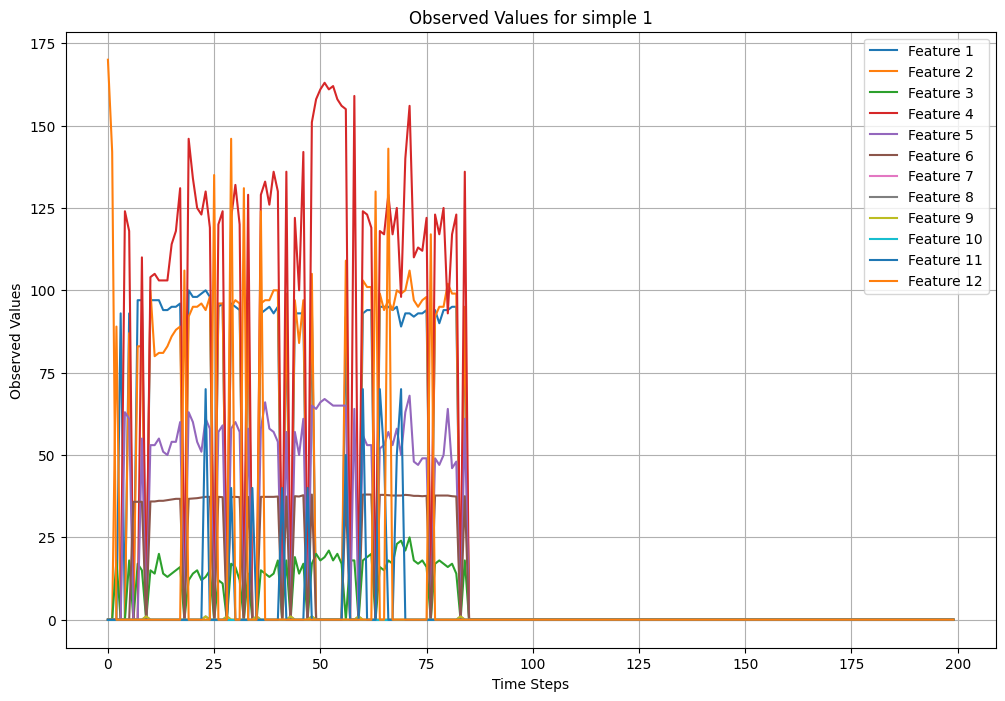

In [19]:
import matplotlib.pyplot as plt

sample_index=0
time_steps=np.arange(200)

plt.figure(figsize=(12,8))
for i in range(12):
    plt.plot(time_steps, x[sample_index, i, :], label=f'Feature {i+1}')
    
plt.xlabel('Time Steps')
plt.ylabel('Observed Values')
plt.title(f'Observed Values for simple {sample_index + 1}')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


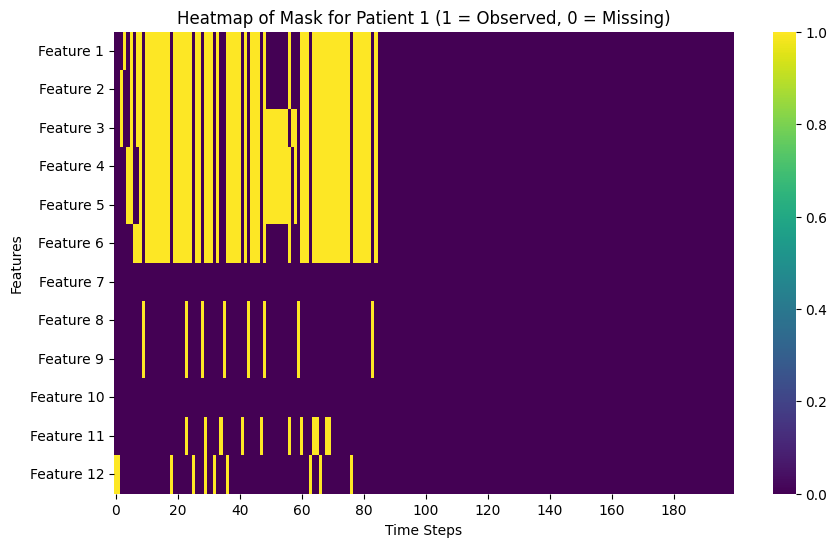

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the mask matrix for a single patient using a heatmap
sample_index = 0  # Change this to visualize other patients

plt.figure(figsize=(10, 6))
sns.heatmap(M[sample_index], cmap="viridis", cbar=True, xticklabels=20, yticklabels=[f'Feature {i+1}' for i in range(12)])

plt.xlabel('Time Steps')
plt.ylabel('Features')
plt.title(f'Heatmap of Mask for Patient {sample_index + 1} (1 = Observed, 0 = Missing)')
plt.show()


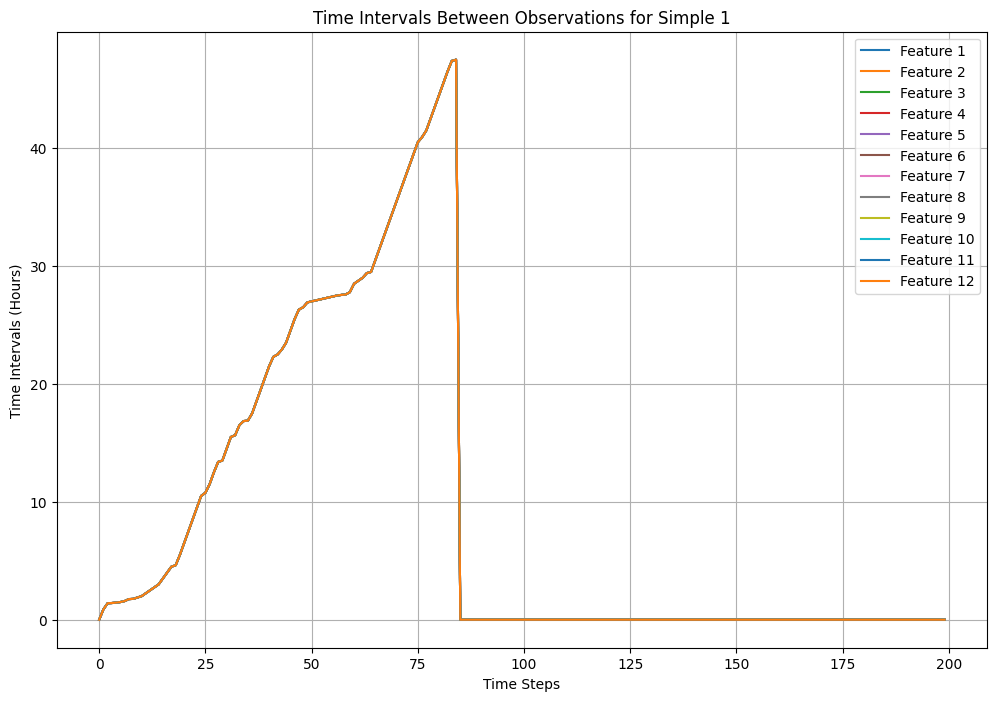

In [21]:
# Visualizing time intervals (delta) for the same sample (sample_index = 0)
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.plot(time_steps, delta[sample_index, i, :], label=f'Feature {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Time Intervals (Hours)')
plt.title(f'Time Intervals Between Observations for Simple {sample_index + 1}')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [22]:
# x = np.concatenate((x, M, delta), axis=1)
# print(x.shape)
# y= np.array(label)
# print(y.shape)

In [23]:
# np.savez('preprocessed_5000.npz', array1=x, array2=y)

# Reference

* https://github.com/amazon-science/chronos-forecasting/issues/13